In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [1]:
!wget "https://raw.githubusercontent.com/Rouzbehrahimi/Advanced_python/master/hour.csv"

--2019-05-16 14:34:15--  https://raw.githubusercontent.com/Rouzbehrahimi/Advanced_python/master/hour.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.0.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1156736 (1.1M) [text/plain]
Saving to: 'hour.csv'

hour.csv            100%[===================>]   1.10M  3.13MB/s    in 0.4s    

2019-05-16 14:34:16 (3.13 MB/s) - 'hour.csv' saved [1156736/1156736]



In [5]:
df_dask=dd.read_csv("hour.csv")
df_dask=df_dask.set_index('instant')
df_dask=df_dask.repartition(npartitions=10)
df_dask.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1.EDA

###  1.1. Identifying null values
##### According to the below the code this dataset does not have any null value.

In [6]:
df_dask.isnull().sum().compute()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [7]:
df_dask=df_dask.rename(
    columns={
        "dteday": "datetime",
        "weathersit": "weather_condition",
        "cnt": "total_bike_rented",
    }
)

In [8]:
df_dask['datetime']= dd.to_datetime(df_dask.datetime, format='%Y-%m-%d')

In [9]:
features_to_transform = [
    "season",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weather_condition",
]

In [10]:
def type_shifter(df, features, new_type):
    """this function takes the selected features of a data frame and 
    cast them to the new_type"""
    for i in features:
        df[i] = df[i].astype(new_type)
    return df.info()

In [11]:
type_shifter(df_dask, features_to_transform, "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, datetime to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4), int64(3)

### Renaming the categorical variables' levels:

#### In the priginal dataset all the weekdays and months are presented as integer, although we have already casted them to categorical type, in order to make them more informative, we would change the levels' names:

In [12]:
df_dask["weekday"] = df_dask["weekday"].map(
    {
        0: "Sunday",
        1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
    }
)

**Here we will check which season is which numbner based on the unique months based on that season**

In [13]:
df_dask[df_dask["season"] == 1]["mnth"].unique().compute()  # Seems like Winter

0     1
1     2
2     3
3    12
Name: mnth, dtype: category
Categories (4, int64): [1, 2, 3, 12]

In [14]:
df_dask[df_dask["season"] == 2]["mnth"].unique().compute()  # Seems like Spring

0    3
1    4
2    5
3    6
Name: mnth, dtype: category
Categories (4, int64): [3, 4, 5, 6]

In [15]:
df_dask[df_dask["season"] == 3]["mnth"].unique().compute()  # Seems like Summer

0    6
1    7
2    8
3    9
Name: mnth, dtype: category
Categories (4, int64): [6, 7, 8, 9]

In [16]:
df_dask[df_dask["season"] == 4]["mnth"].unique().compute()  # Seems like Autumn

0     9
1    10
2    11
3    12
Name: mnth, dtype: category
Categories (4, int64): [9, 10, 11, 12]

In [17]:
df_dask["season"] = df_dask["season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [18]:
df_dask["mnth"] = df_dask["mnth"].map(
    {
        1: "01-Jan",
        2: "02-Feb",
        3: "03-Mar",
        4: "04-Apr",
        5: "05-May",
        6: "06-Jun",
        7: "07-Jul",
        8: "08-Aug",
        9: "09-Sep",
        10: "10-Oct",
        11: "11-Nov",
        12: "12-Dec",
    }
)

In [19]:
df_dask["yr"] = df_dask["yr"].map({0: "2011", 1: "2012"})

In [20]:
df_dask["weather_condition"] = df_dask["weather_condition"].map({1: "A", 2: "B", 3: "C", 4: "D"})

In [21]:
df_dask.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
instant,,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.2879,0.75,0.0,0,1,1


### Visualization
#### In order to see if there is any specific trend in different time intervals we present the target variable over month, day and hour to get a more clear vision of the target variable evolution.

In [22]:
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "large",
    "axes.titlesize": "large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
}

plt.rcParams.update(params)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


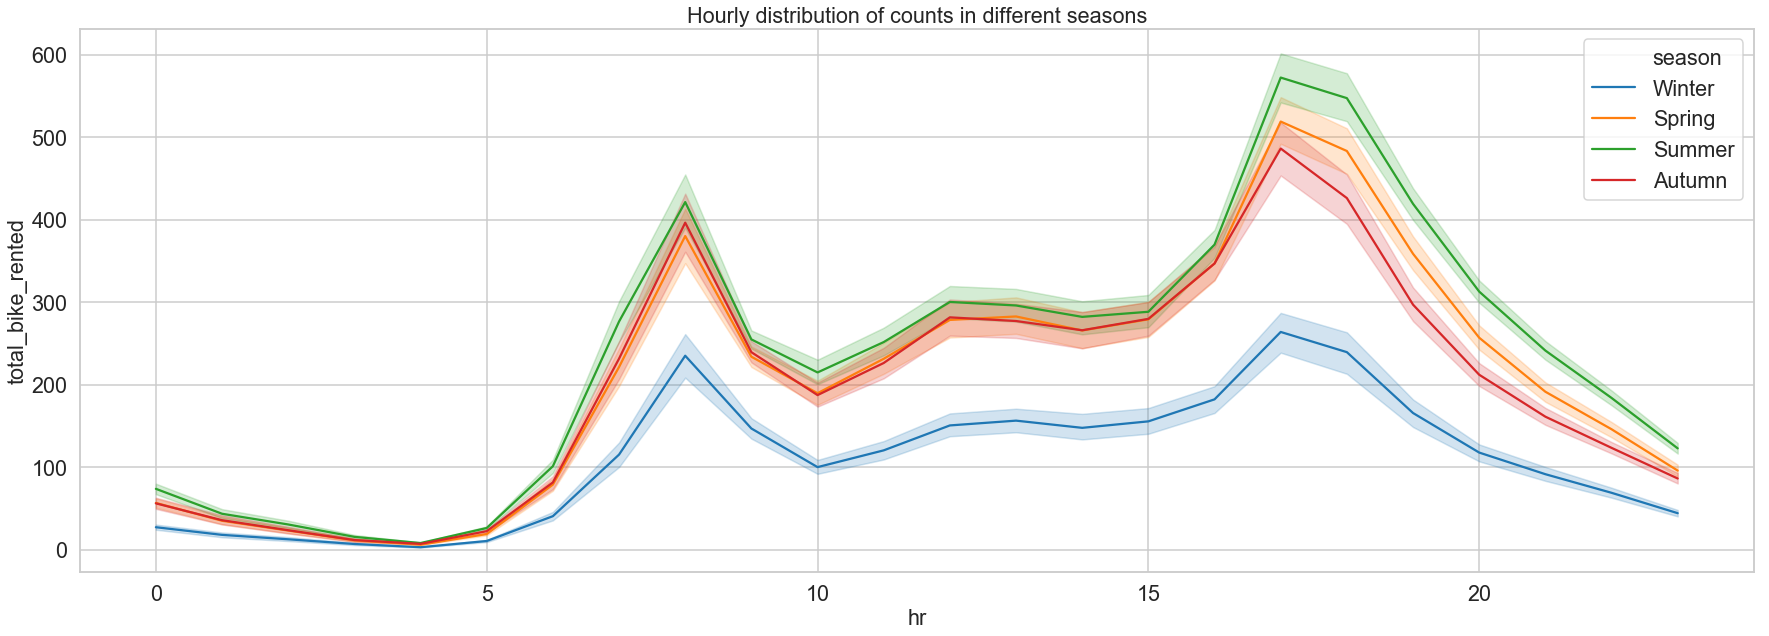

In [23]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["hr", "total_bike_rented", "season"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
    
)
ax.set(title="Hourly distribution of counts in different seasons");


#### The above graph shows that bike rental business is fairly seasonal and aslo correlated with the day time.

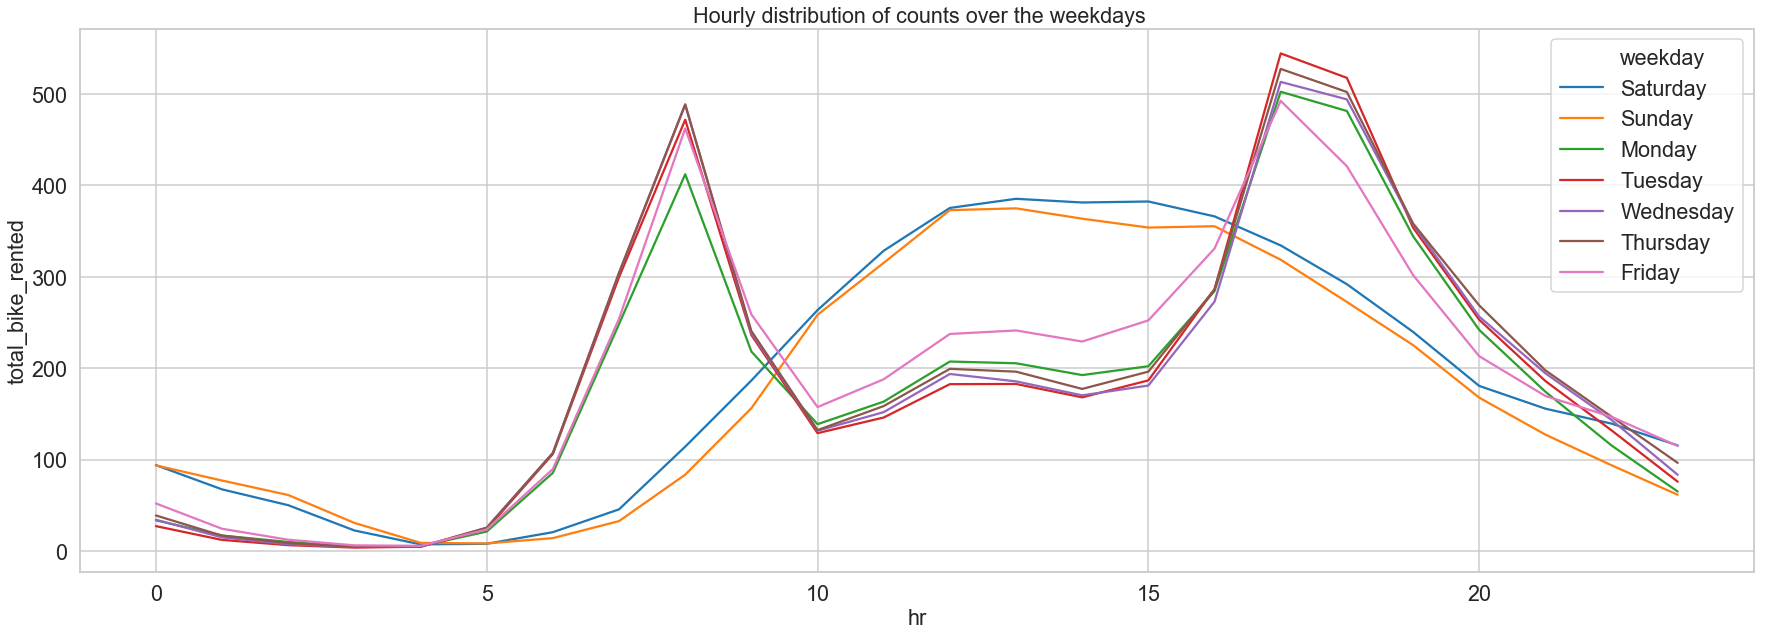

In [24]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["hr", "total_bike_rented", "weekday"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None,
)
ax.set(title=" Hourly distribution of counts over the weekdays");

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


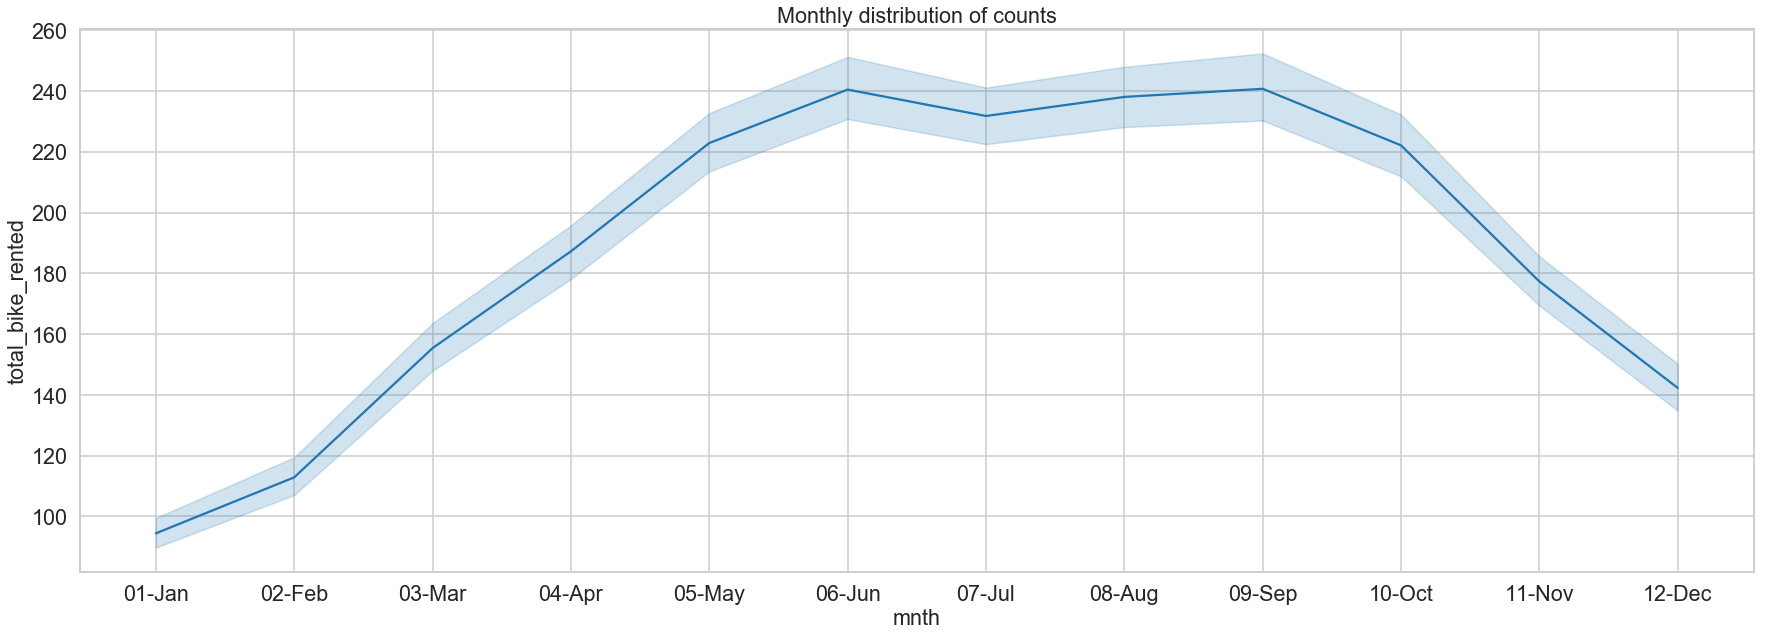

In [25]:
fig, ax = plt.subplots()
sns.lineplot(
    data=df_dask[["mnth", "total_bike_rented", "yr"]].compute(), x="mnth", y="total_bike_rented", ax=ax
)
ax.set(title="Monthly distribution of counts");

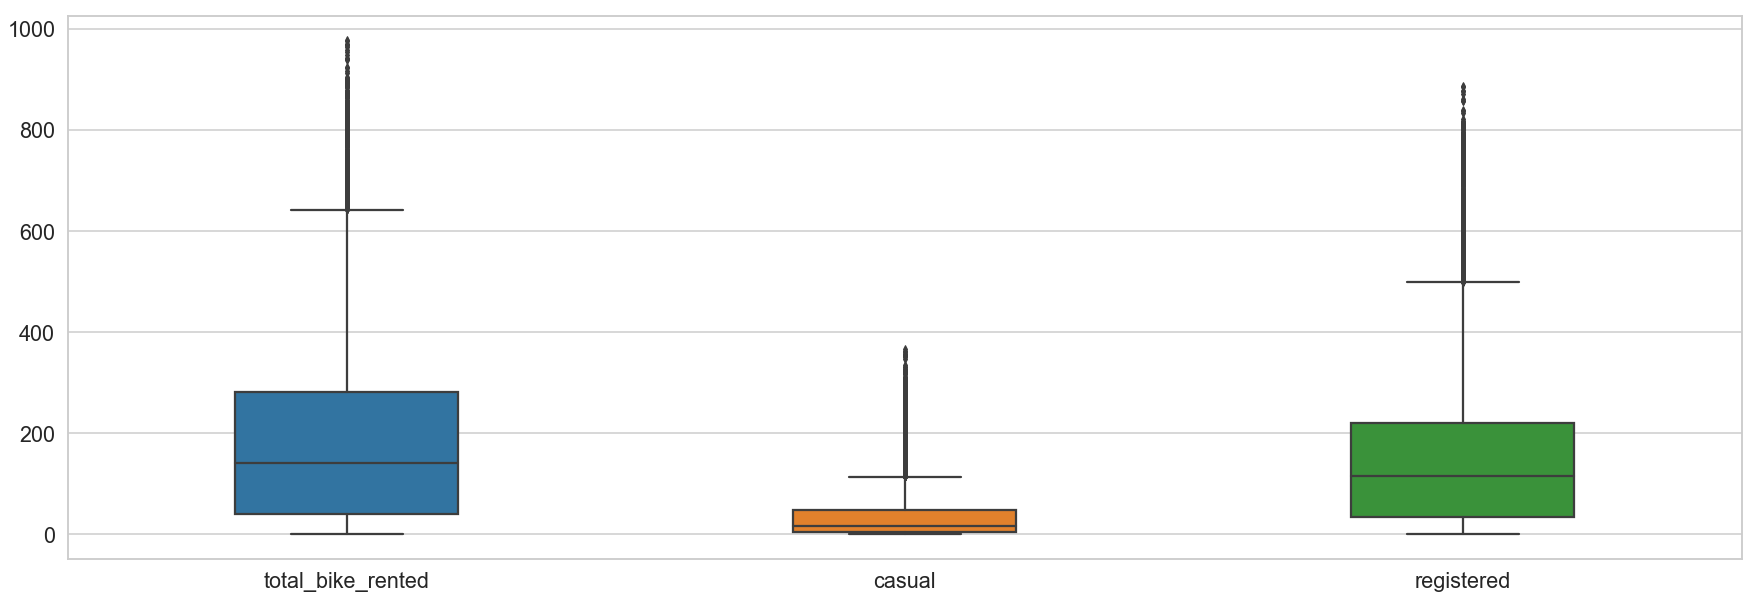

In [26]:
fig, ax = plt.subplots()
sns.boxplot(data=df_dask[["total_bike_rented", "casual", "registered"]].compute(), ax=ax, width=0.4);

### Features correlation

#### In order to avoid futrther error in the modeling part it is better to remove potential multicollinearity between features; therefore, we should measure the correlation coefficient between different featuers.

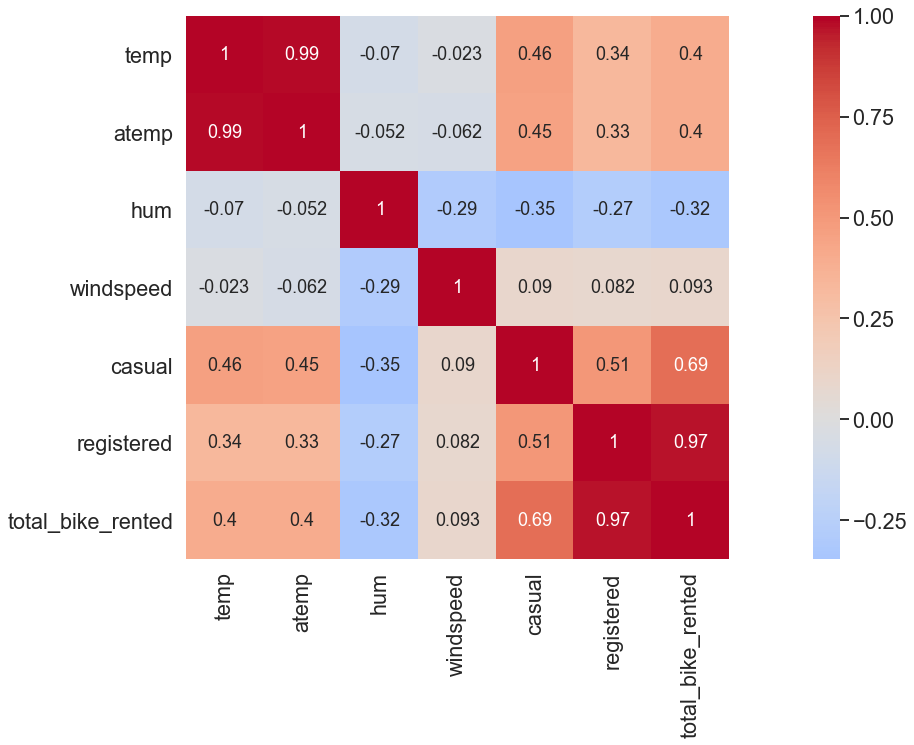

In [27]:
correlation = df_dask[
    ["temp", "atemp", "hum", "windspeed", "casual", "registered", "total_bike_rented"]
].compute().corr()
# correlation.style.background_gradient(cmap='GnBu').set_precision(2)
sns.heatmap(correlation, cmap="coolwarm", square=True, center=0, annot=True);

##### As could be seen above atemp and temp are highly correlated so we will only keep temp and drop the atem from the dataset and other side we cannot say that anu other feature is absolutely useless for Predicting the target Variable so we will keep the other numeric features.

In [28]:
df_dask=df_dask.drop("atemp",axis=1)

###### Casual and registered are a division of total bikes rented so we canot use them to predict the total bikes rented or our model will be a sum of both

In [29]:
df_dask=df_dask.drop(["casual", "registered"], axis=1)

In [30]:
df_dask.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
instant,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1


### Exploring numeric features:

Linear regression algorithm is highly sensitive to the numerical features distribution and also outliers. It means if numeric features are highly skewd probably the regression model would be affected in a negative way. Outliers also are quiet important, and having some outliers in a linear model could change the result totally; therefore in this part we focus on cleaning the numeric values.

In [31]:
numeric_cols = list(df_dask.select_dtypes(include=np.number).columns.values)
numeric_cols

['temp', 'hum', 'windspeed', 'total_bike_rented']

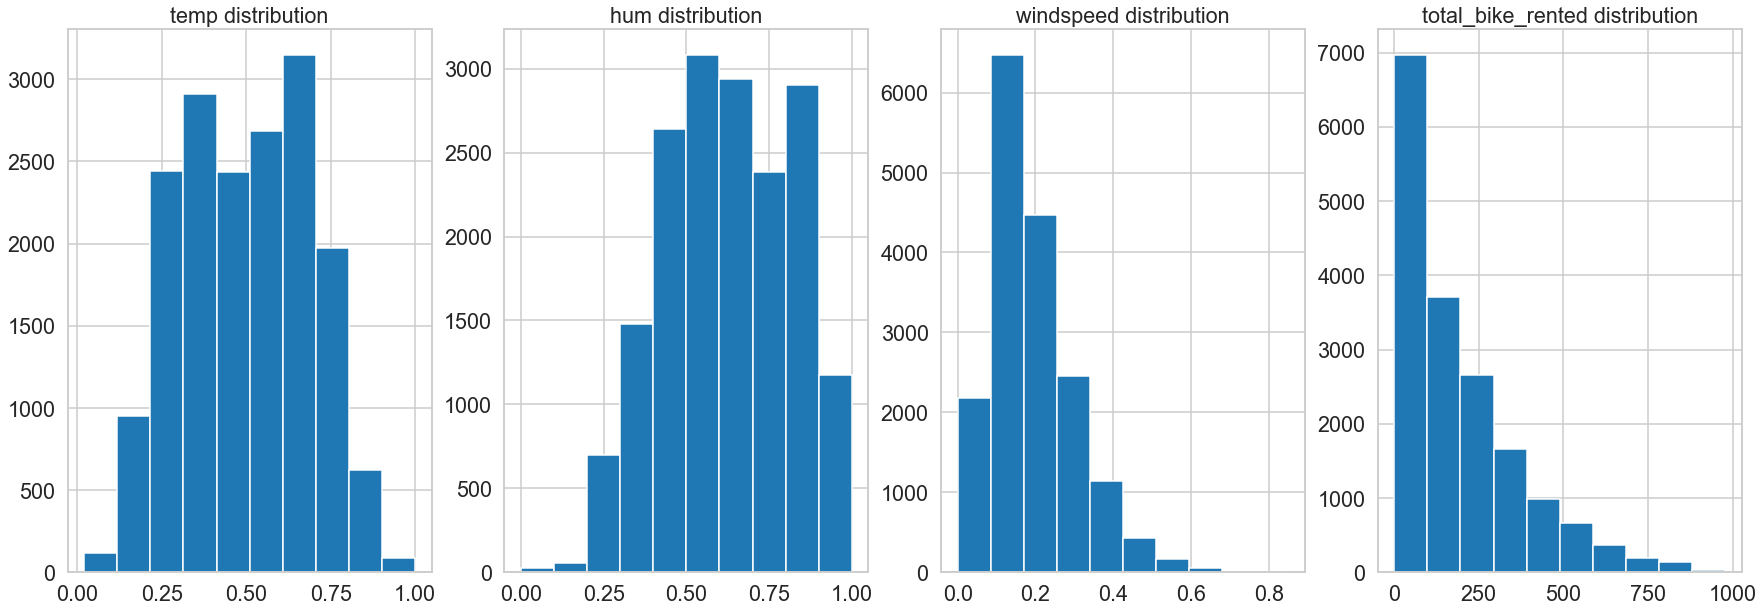

In [32]:
counter = 1
for i in df_dask[numeric_cols].columns.values:
    plt.subplot(1, len(numeric_cols), counter)
    plt.hist(df_dask[i].compute())
    plt.title(str(i) + " " + "distribution")
    counter += 1

#### Considering the sensiticity of the Linear regression model to numeric features' skewness we try modifiy this by transforming variables with skewness higher than our threshold.

In [33]:
from scipy.stats import skew

In [34]:
df_dask[["windspeed", "hum", "temp", "total_bike_rented"]].compute().apply(
    lambda x: abs(skew(x)) > 0.75
)

windspeed            False
hum                  False
temp                 False
total_bike_rented     True
dtype: bool

###### As could be seen above our target variable is highly skewed and needs to get transformed. Doing so, we take sqaure root of the target variable and the skewness would be in the acceptabel range now:

In [35]:
skew(np.log(df_dask.total_bike_rented))

-0.9361009597655617

#### As log transformation in this case cannot remove the skewness we try with sqrt

In [36]:
skew(np.sqrt(df_dask.total_bike_rented))

0.28644988648376024

In [37]:
df_dask["total_bike_rented"] = np.sqrt(df_dask.total_bike_rented)
df_dask.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
instant,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,4.000000
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,6.324555
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,5.656854
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,3.605551
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1.000000


#### Outliers:


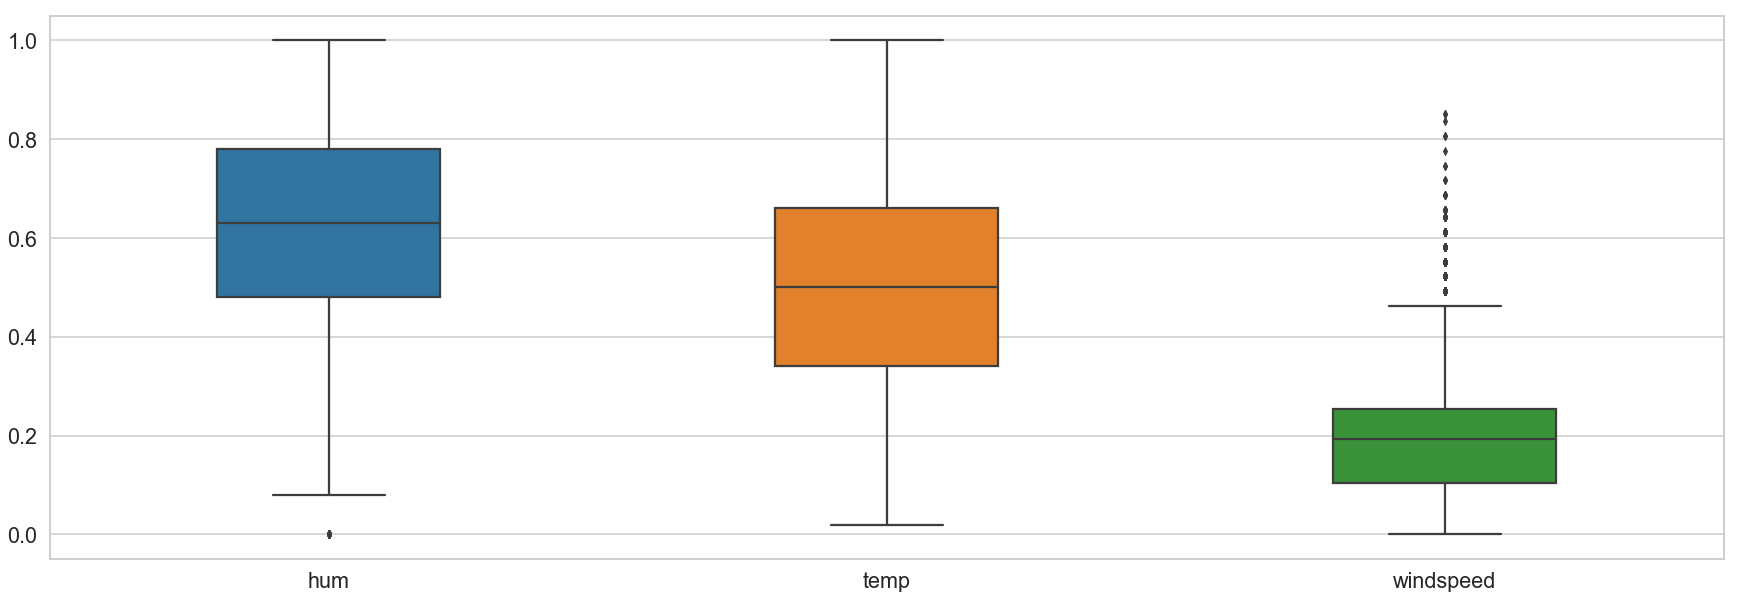

In [38]:
fig, ax = plt.subplots()
sns.boxplot(data=df_dask[["hum", "temp", "windspeed"]].compute(), ax=ax, width=0.4);

#### Exploring the boxplots for univariate analysis of outliers it seems that the numeric features containing outliers are hum and windspeed, however it is not enough yet to consider those points outliers. Therefore we do a multivariate analysis of windspeed and target variable to see if we can get more information.

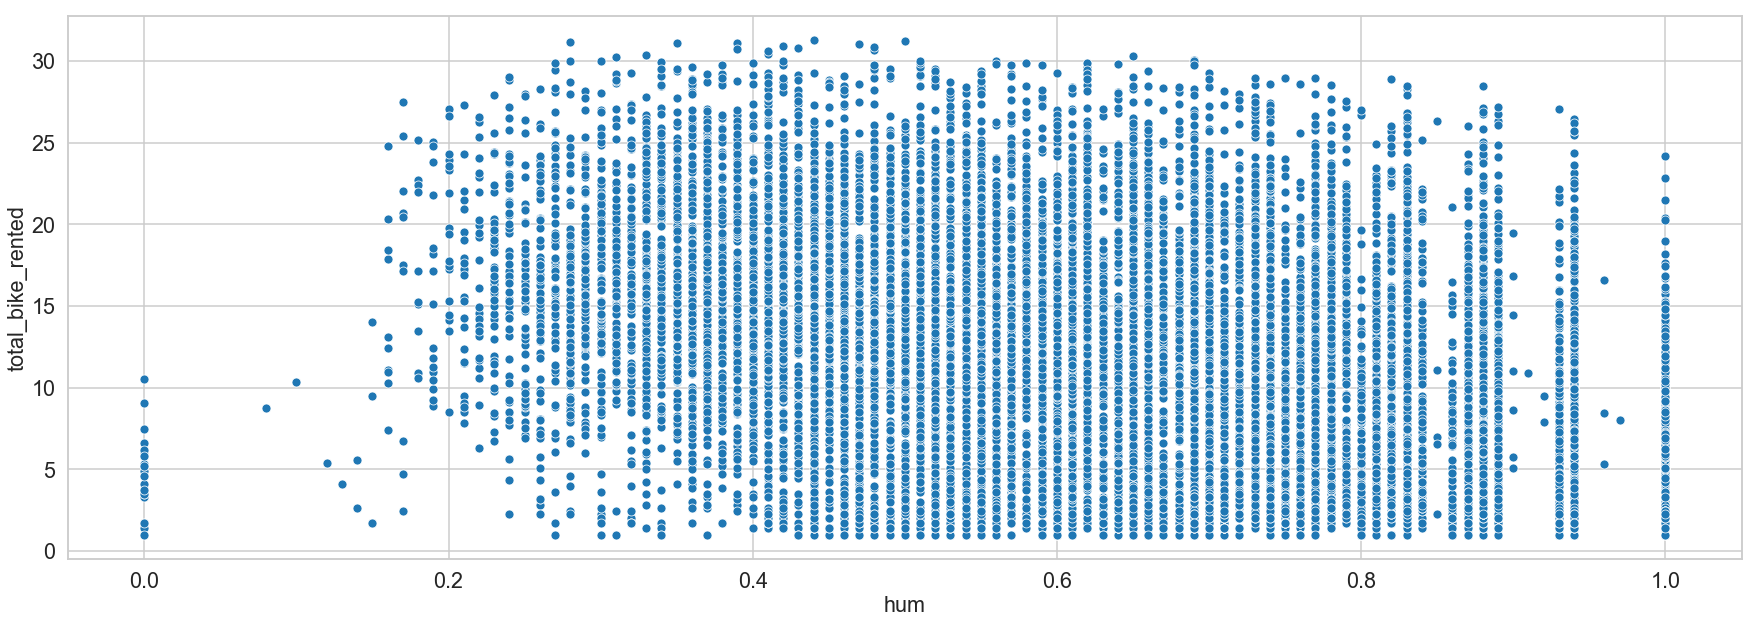

In [39]:
sns.scatterplot(df_dask["hum"].compute(), df_dask["total_bike_rented"].compute());

In [40]:
df_dask['hum']=df_dask['hum'].clip(lower=0.1)

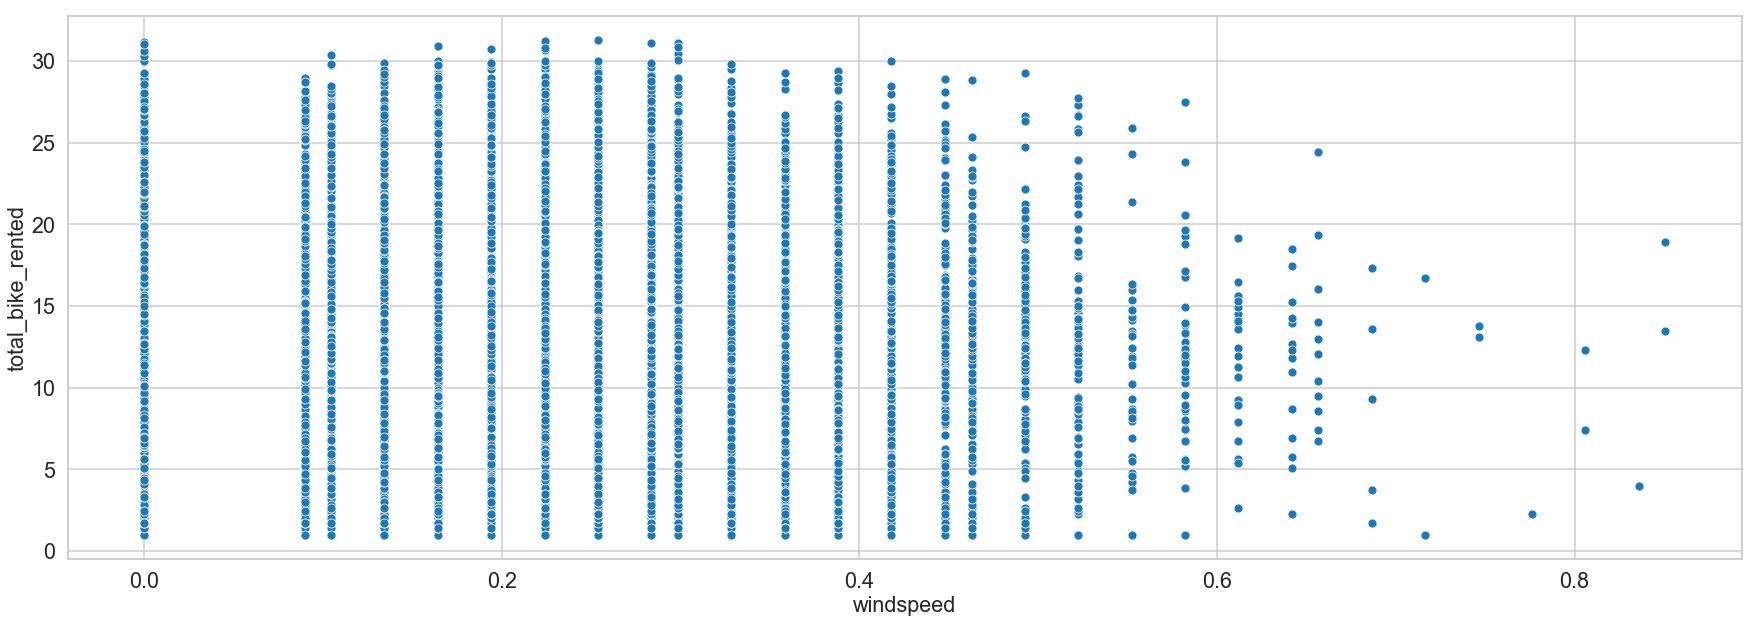

In [41]:
sns.scatterplot(df_dask["windspeed"].compute(), df_dask["total_bike_rented"].compute());

##### The above scatter plot shows that probably winspeed values over 0.7 could be consider outliers, therefore our strategy at this point is to clip the windspeed values over 0.7 to o.7.

In [42]:
df_dask["windspeed"]=df_dask["windspeed"].clip(upper=0.7)

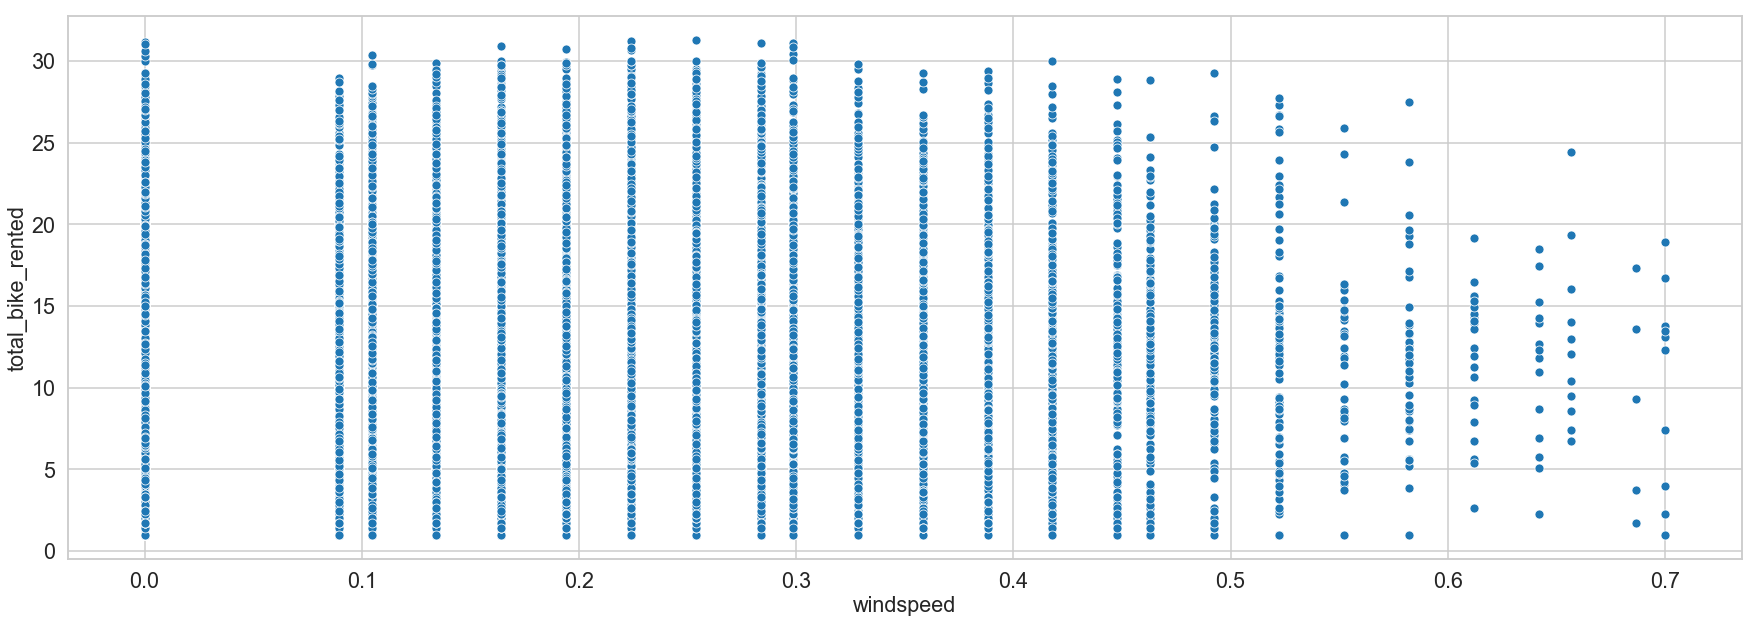

In [43]:
sns.scatterplot(df_dask["windspeed"].compute(), df_dask["total_bike_rented"].compute());

#### Converting categoriacal features to dummy variables.

In [44]:
df_dask.dtypes

datetime             datetime64[ns]
season                       object
yr                           object
mnth                         object
hr                         category
holiday                    category
weekday                      object
workingday                 category
weather_condition            object
temp                        float64
hum                         float64
windspeed                   float64
total_bike_rented           float64
dtype: object

In [45]:
type_shifter(df_dask, ['season','yr','mnth','weekday','weather_condition'], "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 13 entries, datetime to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4)

In [46]:
df_dask.dtypes

datetime             datetime64[ns]
season                     category
yr                         category
mnth                       category
hr                         category
holiday                    category
weekday                    category
workingday                 category
weather_condition          category
temp                        float64
hum                         float64
windspeed                   float64
total_bike_rented           float64
dtype: object

In [47]:
df_dask.columns[df_dask.dtypes=='category']

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weather_condition'],
      dtype='object')

In [48]:
from dask_ml.preprocessing import DummyEncoder 

In [49]:
df_dask[
    [
        "season",
        "yr",
        "mnth",
        "hr",
        "holiday",
        "weekday",
        "workingday",
        "weather_condition",
    ]
] = df_dask[
    [
        "season",
        "yr",
        "mnth",
        "hr",
        "holiday",
        "weekday",
        "workingday",
        "weather_condition",
    ]
].categorize()

In [50]:
de = DummyEncoder()
df_encoded = de.fit_transform(df_dask)

In [51]:
df_encoded.head()

,datetime,temp,hum,windspeed,total_bike_rented,season_Winter,season_Spring,season_Summer,season_Autumn,yr_2011,...,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_0,workingday_1,weather_condition_A,weather_condition_B,weather_condition_C,weather_condition_D
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,0.24,0.81,0.0,4.000000,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,2011-01-01,0.22,0.80,0.0,6.324555,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
3,2011-01-01,0.22,0.80,0.0,5.656854,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,2011-01-01,0.24,0.75,0.0,3.605551,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
5,2011-01-01,0.24,0.75,0.0,1.000000,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


#### As we are going to use the last quarter of 2012 as the test set we will keep the index from which this quarter starts and it is 15212.

#### Having finished the feature engineering part, we move to creating model

In [52]:
y = df_encoded[["total_bike_rented"]]
X = df_encoded.drop(["datetime", "total_bike_rented"], axis=1)

In [53]:
X_train = X[:15211]
X_test = X[15211:]
y_train = y[:15211]
y_test = y[15211:]

### Trying with Linear regression


In [54]:
from dask_ml.linear_model import LinearRegression

In [55]:
from sklearn.metrics import r2_score

In [56]:
lr = LinearRegression()
lr.fit(X_train.values, y_train.values)

LinearRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
         intercept_scaling=1.0, max_iter=100, multi_class='ovr', n_jobs=1,
         penalty='l2', random_state=None, solver='admm',
         solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [57]:
y_test_pred=lr.predict(X_test.values)

In [58]:
(y_test_pred.compute())

array([12.86270441, 10.0607501 ,  8.19918908, ..., 12.80281894,
       11.45974791,  9.21194325])

In [59]:
r2_score(y_test['total_bike_rented'].values.compute(),y_test_pred.compute())

0.7211845762330499